In [ ]:
import sys
import os
import pandas as pd
import numpy as np
from datetime import date
import talib
from sklearn.linear_model import *
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import accuracy_score
from sktime.forecasting.model_selection import SlidingWindowSplitter
from joblib import Parallel, delayed
from itertools import islice
import json
import warnings
import matplotlib.pyplot as plt

In [ ]:
root_data_dir = "/projects/genomic-ml/da2343/ml_project_2/data" 
dataset_path = f"{root_data_dir}/EURUSD/EURUSD_H1_200702210000_202304242100_Update.csv"
# Load the config file
config_path = "/projects/genomic-ml/da2343/ml_project_2/settings/config.json"
with open(config_path) as f:
  config = json.load(f)
  
dataset_name = "EURUSD_H1"
# Get the take_profit and stop_loss levels from the config file
tp = config["trading_settings"][dataset_name]["take_profit"]
sl = config["trading_settings"][dataset_name]["stop_loss"]
df = pd.read_csv(dataset_path, index_col=0)

y = df[['Close']]
offset = y.index[0]

In [ ]:
df

## GENERATE SEQUENTIAL TRADE DATA

In [ ]:
def create_trade_order(row, position, tp, sl):
    ask_price = row["Close"]
    tp_price = ask_price + tp if position == 1 else ask_price - tp
    sl_price = ask_price - sl if position == 1 else ask_price + sl

    trade_order = {
        "index": row.name,
        "ask_price": ask_price,
        "take_profit_price": tp_price,
        "stop_loss_price": sl_price,
        "position": position,
        # f"SMA_{timeperiod}": row[f"SMA_{timeperiod}"],
        "MACD": row["MACD"],
        "MACD_Signal": row["MACD_Signal"],
        "MACD_Hist": row["MACD_Hist"],
        "MACD_Crossover_Change" : row["MACD_Crossover_Change"],
        "RSI": row["RSI"],
        "ATR": row["ATR"],
        "ADX": row["ADX"],
        "AROON_Oscillator": row["AROON_Oscillator"],
        "WILLR": row["WILLR"],
        "OBV": row["OBV"],
        "CCI": row["CCI"],
        "PSAR": row["PSAR"],
        "AD": row["AD"],
        "ADOSC": row["ADOSC"],
        "VOLUME_RSI": row["VOLUME_RSI"],
        "MFI": row["MFI"],
        "Date_Time": row["Date_Time"],
        "close_time": None,
        "label": None,
    }
    return trade_order


trades = []
# loop through all rows in the dataframe
for index, row in df.iterrows():
    i = index + offset

    if len(trades) != 0:
        prev_trade = trades[-1]
        # check if the previous trade was a long trade
        if prev_trade["position"] == 1:
            if row["Close"] >= prev_trade["take_profit_price"] and prev_trade["label"] == None:
                prev_trade["label"] = 1
                prev_trade["close_time"] = row["Date_Time"]
                continue
            elif row["Close"] <= prev_trade["stop_loss_price"] and prev_trade["label"] == None:
                prev_trade["label"] = 0
                prev_trade["close_time"] = row["Date_Time"]
                continue
        else:
            if row["Close"] <= prev_trade["take_profit_price"] and prev_trade["label"] == None:
                prev_trade["label"] = 1
                prev_trade["close_time"] = row["Date_Time"]
                continue
            elif row["Close"] >= prev_trade["stop_loss_price"] and prev_trade["label"] == None:
                prev_trade["label"] = 0
                prev_trade["close_time"] = row["Date_Time"]
                continue
                
        if prev_trade["label"] == None:
            continue
   
    macd_crossover_change = row["MACD_Crossover_Change"]
    if macd_crossover_change > 0 or macd_crossover_change < 0:
        current_position = 1 if macd_crossover_change > 0 else 0
        local_order = create_trade_order(row, current_position, tp, sl)
        trades.append(local_order) 

trades_df = pd.DataFrame(trades)

In [ ]:
trades_df

In [ ]:
# 2359 rows × 24 columns
# save the trades dataframe to a csv file
trades_df.to_csv(f"trades_seq_{dataset_name}_2007_2023.csv", index=False)

## GENERATE NON-SEQUENTIAL TRADE DATA

In [ ]:
##TODO: Fix this code before running it

def save_setup_graph(subset_df, position, label):
    plt.figure(figsize=(7,4))
    plt.plot(subset_df["Close"], label="Close")
    plt.plot(subset_df["SMA_20"], label="SMA_20")
    # plt.plot(df["SMA_30"], label="SMA_30")
    plt.plot(subset_df["SMA_50"], label="SMA_50")
    plt.plot(subset_df["SMA_100"], label="SMA_100")
    close_price = subset_df["Close"].iloc[-1]
    if position == 1:
        plt.axhspan(close_price, close_price + tp, facecolor="green", xmin= 0.96, alpha=0.5) 
        plt.axhspan(close_price - sl, close_price, facecolor="red", xmin= 0.96, alpha=0.5)
    else:
        plt.axhspan(close_price, close_price + sl, facecolor="red", xmin= 0.96, alpha=0.5) 
        plt.axhspan(close_price - tp, close_price, facecolor="green", xmin= 0.96, alpha=0.5)
    plt.xticks([])
    plt.yticks([])
    save_path = f"/projects/genomic-ml/da2343/ml_project_2/data/EURUSD/{label}"
    # name should be the index of the first row in the subset_df
    plt.savefig(f"{save_path}/{subset_df.index[0]}.png", dpi=300, bbox_inches="tight")
    


trades = []
window_size = 24 * 10

# loop through all rows in the dataframe
for index in range(window_size, len(df)):
    i = index + offset

    if df.loc[i, "MACD_Crossover_Change"] > 0:
        ask_price = df.loc[i, "Close"]
        tp_price = ask_price + tp
        sl_price = ask_price - sl
        current_position = 1

        local_order = {
            "index": i,
            "ask_price": ask_price,
            "take_profit_price": tp_price,
            "stop_loss_price": sl_price,
            "position": current_position,
            # f"SMA_{timeperiod}": df.loc[i, f"SMA_{timeperiod}"],
            "MACD": df.loc[i, "MACD"],
            "MACD_Signal": df.loc[i, "MACD_Signal"],
            "MACD_Hist": df.loc[i, "MACD_Hist"],
            "RSI": df.loc[i, "RSI"],
            "ATR": df.loc[i, "ATR"],
            "ADX": df.loc[i, "ADX"],
            "AROON_Oscillator": df.loc[i, "AROON_Oscillator"],
            "WILLR": df.loc[i, "WILLR"],
            "OBV": df.loc[i, "OBV"],
            "CCI": df.loc[i, "CCI"],
            "PSAR": df.loc[i, "PSAR"],
            "AD": df.loc[i, "AD"],
            "ADOSC": df.loc[i, "ADOSC"],
            "VOLUME_RSI": df.loc[i, "VOLUME_RSI"],
            "MFI": df.loc[i, "MFI"],
            "Date_Time": df.loc[i, "Date_Time"],
            "label": None,
        }
        # add a second loop to check if the current close price is greater than the take profit price
        # or less than the stop loss price
        for k in range(index+1, len(df)):
            j = k + offset
            if df.loc[j, "Close"] >= tp_price:
                local_order["label"] = 1
                local_order["close_time"] = df.loc[j, "Date_Time"]
                break
            elif df.loc[j, "Close"] <= sl_price:
                local_order["label"] = 0
                local_order["close_time"] = df.loc[j, "Date_Time"]
                break
        
        # create set-up graph for local_order
        # subset_df should be a df with window_size rows from i-window_size to i
        subset_df = df.loc[i-window_size:i]
        save_setup_graph(subset_df, current_position, local_order["label"])
        trades.append(local_order)
        
        
    elif df.loc[i, "MACD_Crossover_Change"] < 0:   
        ask_price = df.loc[i, "Close"]  
        tp_price = ask_price - tp
        sl_price = ask_price + sl
        current_position = 0

        local_order = {
            "index": i,
            "ask_price": ask_price,
            "take_profit_price": tp_price,
            "stop_loss_price": sl_price,
            "position": current_position,
            # f"SMA_{timeperiod}": df.loc[i, f"SMA_{timeperiod}"],
            "MACD": df.loc[i, "MACD"],
            "MACD_Signal": df.loc[i, "MACD_Signal"],
            "MACD_Hist": df.loc[i, "MACD_Hist"],
            "RSI": df.loc[i, "RSI"],
            "ATR": df.loc[i, "ATR"],
            "ADX": df.loc[i, "ADX"],
            "AROON_Oscillator": df.loc[i, "AROON_Oscillator"],
            "WILLR": df.loc[i, "WILLR"],
            "OBV": df.loc[i, "OBV"],
            "CCI": df.loc[i, "CCI"],
            "PSAR": df.loc[i, "PSAR"],
            "AD": df.loc[i, "AD"],
            "ADOSC": df.loc[i, "ADOSC"],
            "VOLUME_RSI": df.loc[i, "VOLUME_RSI"],
            "MFI": df.loc[i, "MFI"],
            "Date_Time": df.loc[i, "Date_Time"],
            "label": None,
        }
        
        for k in range(index+1, len(df)):
            j = k + offset
            if df.loc[j, "Close"] <= tp_price:
                local_order["label"] = 1
                local_order["close_time"] = df.loc[j, "Date_Time"]
                break
            elif df.loc[j, "Close"] >= sl_price:
                local_order["label"] = 0
                local_order["close_time"] = df.loc[j, "Date_Time"]
                break
        trades.append(local_order)
        
trades_df = pd.DataFrame(trades)

In [ ]:
trades_df

In [ ]:
# 2359 rows × 24 columns
# save the trades dataframe to a csv file
trades_df.to_csv(f"trades_non_seq_{dataset_name}_2011_2023.csv", index=False)

In [ ]:
# get outcomes from trades_df using the label column
outcomes = trades_df["label"].tolist()

accuracy_df = pd.DataFrame({
    'accuracy': accuracy_score([1] * len(outcomes), outcomes),
    'no_of_trades': len(outcomes),
    'no_of_wins': sum(outcomes),
    'no_of_losses': len(outcomes) - sum(outcomes),
}, index=[0])

In [9]:
import sys
import os
import pandas as pd
import numpy as np
from datetime import date
import talib
from sklearn.linear_model import *
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import accuracy_score
from sktime.forecasting.model_selection import SlidingWindowSplitter
from joblib import Parallel, delayed
from itertools import islice
import json
import warnings
import matplotlib.pyplot as plt


dataset_name = "AUD_CAD_H1"
# root_data_dir = "/projects/genomic-ml/da2343/ml_project_2/data/USDJPY" 
root_data_dir = "/Users/newuser/Projects/robust-algo-trader/data" 
dataset_path = f"{root_data_dir}/oanda/{dataset_name}_processed_data.csv"


# Load the config file
# config_path = "/projects/genomic-ml/da2343/ml_project_2/settings/config.json"
config_path = "/Users/newuser/Projects/robust-algo-trader/settings/config.json"
with open(config_path) as f:
  config = json.load(f)  
# Get the take_profit and stop_loss levels from the config file
config_settings = config["trading_settings"][dataset_name]
tp = config_settings["take_profit"]
sl = config_settings["stop_loss"]
delta = config_settings["delta"]
window_size = config_settings["window_size"]

df = pd.read_csv(dataset_path)
df = df.rename(columns={'time': 'Time'})
df['Index'] = df.index
y = df[['Close']]
offset = y.index[0]

In [10]:
df

,Time,Open,High,Low,Close,Volume,SMA_20,SMA_30,SMA_50,SMA_100,...,STOCH_D,WILLR,BBANDS_Upper,BBANDS_Middle,BBANDS_Lower,AD,ADOSC,VOLUME_RSI,MFI,Index
0,2005-01-03 09:00:00+00:00,0.93783,0.93959,0.93625,0.93756,856,0.939397,0.940370,0.935346,0.926007,...,62.846414,-58.498706,0.938738,0.937776,0.936814,-1196.877489,-328.921643,66.156627,37.103206,0
1,2005-01-03 10:00:00+00:00,0.93739,0.93906,0.93704,0.93853,475,0.938921,0.940525,0.935476,0.926278,...,61.044829,-37.378115,0.938563,0.937740,0.936917,-971.134915,-257.875562,53.432428,41.634078,1
2,2005-01-03 11:00:00+00:00,0.93888,0.93976,0.93774,0.93783,518,0.938974,0.940544,0.935622,0.926574,...,58.472392,-44.962080,0.938591,0.937810,0.937029,-1442.976499,-355.499436,54.496162,45.929356,2
3,2005-01-03 12:00:00+00:00,0.93774,0.94056,0.93629,0.93840,883,0.938923,0.940573,0.935754,0.926830,...,56.613143,-38.786566,0.938776,0.938012,0.937248,-1453.316077,-366.408210,62.356613,39.943983,3
4,2005-01-03 13:00:00+00:00,0.93848,0.94304,0.93804,0.94065,1785,0.939023,0.940629,0.935971,0.927124,...,55.308202,-23.226433,0.940771,0.938594,0.936417,-1374.776077,-312.571054,74.211995,49.070828,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120495,2023-12-22 17:00:00+00:00,0.90202,0.90261,0.90100,0.90234,2140,0.902040,0.902375,0.901686,0.901269,...,33.211245,-48.775056,0.904123,0.902586,0.901049,-483055.321606,-204.384937,45.911439,57.277221,120495
120496,2023-12-22 18:00:00+00:00,0.90238,0.90303,0.90236,0.90282,1496,0.902035,0.902388,0.901720,0.901308,...,31.194288,-38.084633,0.903187,0.902358,0.901529,-482497.112651,20.286286,43.672203,56.874494,120496
120497,2023-12-22 19:00:00+00:00,0.90282,0.90282,0.90170,0.90206,1869,0.901996,0.902337,0.901735,0.901362,...,39.476268,-55.011136,0.903100,0.902416,0.901732,-483164.612651,-102.033331,45.335211,56.905361,120497
120498,2023-12-22 20:00:00+00:00,0.90208,0.90234,0.90142,0.90160,840,0.901965,0.902268,0.901746,0.901410,...,42.773553,-65.256125,0.902975,0.902174,0.901373,-483675.916999,-305.485164,41.679396,58.195294,120498


KeyboardInterrupt: 

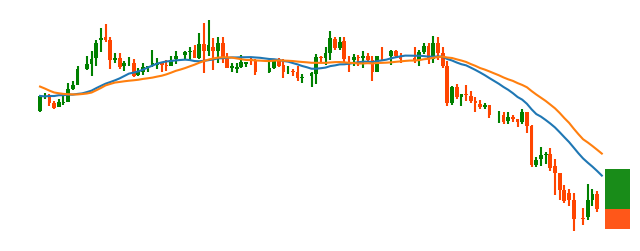

In [11]:

def save_setup_graph(subset_df, position, label, index):
    green_df = subset_df[subset_df['Close'] > subset_df['Open']].copy()
    green_df["Height"] = green_df["Close"] - green_df["Open"]
    red_df = subset_df[subset_df['Close'] < subset_df['Open']].copy()
    red_df["Height"] = red_df["Open"] - red_df["Close"]
    
    fig = plt.figure(figsize=(8, 3))
    
    ##Grey Lines
    plt.vlines(x=green_df["Index"], 
            ymin=green_df["Low"], 
            ymax=green_df["High"],
            color="green")
    plt.vlines(x=red_df["Index"], 
            ymin=red_df["Low"], 
            ymax=red_df["High"],
            color="orangered")
    ##Green Candles
    plt.bar(x=green_df["Index"], 
            height=green_df["Height"], 
            bottom=green_df["Open"], 
            color="green")
    ##Red Candles
    plt.bar(x=red_df["Index"], 
            height=red_df["Height"], 
            bottom=red_df["Close"], 
            color="orangered")
    
    plt.plot(subset_df["SMA_20"], label="SMA_20")
    plt.plot(subset_df["SMA_30"], label="SMA_30")
    
    close_price = subset_df["Close"].iloc[-1]
    
    tp_eps = tp + delta
    sl_eps = sl + delta
    
    sl_eps = sl
    tp_eps = tp
    
    if position == 1:
        plt.axhspan(close_price, close_price + tp_eps, facecolor="green", xmin= 0.96, alpha=0.9) 
        plt.axhspan(close_price - sl_eps, close_price, facecolor="orangered", xmin= 0.96, alpha=0.9)
    else:
        plt.axhspan(close_price, close_price + sl_eps, facecolor="orangered", xmin= 0.96, alpha=0.9) 
        plt.axhspan(close_price - tp_eps, close_price, facecolor="green", xmin= 0.96, alpha=0.9)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    
    # name should be the index of the first row in the subset_df
    # Check if the directory exists, if not, create it
    directory_path = f"{root_data_dir}/{dataset_name}/{label}"
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    plt.savefig(f"{directory_path}/{index}.png", dpi=128, bbox_inches="tight")
    # close the figure
    plt.close()
    

trades = []

# loop through all rows in the dataframe
for index in range(window_size, len(df)):
    i = index + offset

    if df.loc[i, "MACD_Crossover_Change"] > 0:
        ask_price = df.loc[i, "Close"]
        tp_price = ask_price + tp
        sl_price = ask_price - sl
        current_position = 1

        local_order = {
            "index": i,
            "ask_price": ask_price,
            "take_profit_price": tp_price,
            "stop_loss_price": sl_price,
            "position": current_position,
            # f"SMA_{timeperiod}": df.loc[i, f"SMA_{timeperiod}"],
            "MACD": df.loc[i, "MACD"],
            "MACD_Signal": df.loc[i, "MACD_Signal"],
            "MACD_Hist": df.loc[i, "MACD_Hist"],
            "RSI": df.loc[i, "RSI"],
            "ATR": df.loc[i, "ATR"],
            "ADX": df.loc[i, "ADX"],
            "AROON_Oscillator": df.loc[i, "AROON_Oscillator"],
            "WILLR": df.loc[i, "WILLR"],
            "OBV": df.loc[i, "OBV"],
            "CCI": df.loc[i, "CCI"],
            "PSAR": df.loc[i, "PSAR"],
            "AD": df.loc[i, "AD"],
            "ADOSC": df.loc[i, "ADOSC"],
            "VOLUME_RSI": df.loc[i, "VOLUME_RSI"],
            "MFI": df.loc[i, "MFI"],
            "Time": df.loc[i, "Time"],
            "label": None,
        }
        # add a second loop to check if the current close price is greater than the take profit price
        # or less than the stop loss price
        for k in range(index+1, len(df)):
            j = k + offset
            if df.loc[j, "Close"] >= tp_price:
                local_order["label"] = 1
                local_order["close_time"] = df.loc[j, "Time"]
                break
            elif df.loc[j, "Close"] <= sl_price:
                local_order["label"] = 0
                local_order["close_time"] = df.loc[j, "Time"]
                break
        
        if local_order["label"] is None:
            break    
        
        
        # create set-up graph for local_order
        # subset_df should be a df with window_size rows from i-window_size to i
        subset_df = df.loc[i-window_size:i]
        save_setup_graph(subset_df, current_position, local_order["label"], i)
        trades.append(local_order)
        
        
    elif df.loc[i, "MACD_Crossover_Change"] < 0:   
        ask_price = df.loc[i, "Close"]  
        tp_price = ask_price - tp
        sl_price = ask_price + sl
        current_position = 0

        local_order = {
            "index": i,
            "ask_price": ask_price,
            "take_profit_price": tp_price,
            "stop_loss_price": sl_price,
            "position": current_position,
            # f"SMA_{timeperiod}": df.loc[i, f"SMA_{timeperiod}"],
            "MACD": df.loc[i, "MACD"],
            "MACD_Signal": df.loc[i, "MACD_Signal"],
            "MACD_Hist": df.loc[i, "MACD_Hist"],
            "RSI": df.loc[i, "RSI"],
            "ATR": df.loc[i, "ATR"],
            "ADX": df.loc[i, "ADX"],
            "AROON_Oscillator": df.loc[i, "AROON_Oscillator"],
            "WILLR": df.loc[i, "WILLR"],
            "OBV": df.loc[i, "OBV"],
            "CCI": df.loc[i, "CCI"],
            "PSAR": df.loc[i, "PSAR"],
            "AD": df.loc[i, "AD"],
            "ADOSC": df.loc[i, "ADOSC"],
            "VOLUME_RSI": df.loc[i, "VOLUME_RSI"],
            "MFI": df.loc[i, "MFI"],
            "Time": df.loc[i, "Time"],
            "label": None,
        }
        
        for k in range(index+1, len(df)):
            j = k + offset
            if df.loc[j, "Close"] <= tp_price:
                local_order["label"] = 1
                local_order["close_time"] = df.loc[j, "Time"]
                break
            elif df.loc[j, "Close"] >= sl_price:
                local_order["label"] = 0
                local_order["close_time"] = df.loc[j, "Time"]
                break
        
        if local_order["label"] is None:
            break
        
        subset_df = df.loc[i-window_size:i]
        save_setup_graph(subset_df, current_position, local_order["label"], i)
        trades.append(local_order)
        
# trades_df = pd.DataFrame(trades)
print("Done!")
